In [54]:
# Cell 1: Install and import dependencies
# conda create -n kf_py312 python=3.12
# conda activate kf_py312
# pip install ipykernel uproot h5py numpy torch scikit-learn
# # with conda (not required)
# conda install -c conda-forge openssl sqlite
## In Ubuntu do:
# sudo apt update
# sudo apt --fix-broken install
# sudo apt install \
#  libsqlite3-0=3.37.2-2ubuntu0.4 \
#  libsqlite3-dev=3.37.2-2ubuntu0.4 \
#  sqlite3=3.37.2-2ubuntu0.4
# sudo apt-mark hold libsqlite3-0 libsqlite3-dev sqlite3

import sys
import os, glob
import h5py
import uproot
import numpy as np
import pandas as pd
import awkward as ak
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

print("=== Environment Versions ===")
print("Python:", sys.version.split()[0])
print("NumPy: ", np.__version__)
print("Pandas:", pd.__version__)
print("Awkward:", ak.__version__)
print("PyTorch:", torch.__version__)
print("=============================")

=== Environment Versions ===
Python: 3.12.11
NumPy:  2.0.1
Pandas: 2.2.3
Awkward: 2.8.4
PyTorch: 2.7.1+cu126


In [57]:
# Cell 2: Configuration
BASE_DIR_LQ   = "/home/sgoswami/monobcntuples/"
BASE_DIR_STOP = "/home/sgoswami/monobcntuples/run3_btag/all"

# LQ HDF5
LQ_PATTERN = os.path.join(BASE_DIR_LQ, "mass_*", "basicSel_mass_*.h5")
_all_lq    = glob.glob(LQ_PATTERN)
sig_files  = [
    f for f in _all_lq
    if "_histogram" not in os.path.basename(f)
    and "_cutflow"   not in os.path.basename(f)
]

# Stop ROOT
STOP_PATTERN = os.path.join(BASE_DIR_STOP, "singlestop", "basicSel_sT_*_*.root")
_all_stop    = glob.glob(STOP_PATTERN)
stop_files   = [
    f for f in _all_stop
    if "_histogram" not in os.path.basename(f)
    and "_cutflow"   not in os.path.basename(f)
]

selected_variables = [
    "jet1_pt","jet1_eta","jet1met_dphi","met_sig","met_pt"
]

HPARAMS    = "416_160_416_480_0.0001_100_128"
ACTIVATION = "leakyrelu"
OPTIMIZER  = "Adam"
FOLDS      = 5

print(f"Found {len(sig_files)} signal HDF5 files; examples:", sig_files[:3])
print(f"Found {len(stop_files)} stop ROOT files; examples:", stop_files[:3])
print("Selected variables:", selected_variables)
print("Hyperparams:", HPARAMS, "Activation:", ACTIVATION, "Optimizer:", OPTIMIZER, "Folds:", FOLDS)


Found 6 signal HDF5 files; examples: ['/home/sgoswami/monobcntuples/mass_500/basicSel_mass_500.h5', '/home/sgoswami/monobcntuples/mass_2000/basicSel_mass_2000.h5', '/home/sgoswami/monobcntuples/mass_2500/basicSel_mass_2500.h5']
Found 5 stop ROOT files; examples: ['/home/sgoswami/monobcntuples/run3_btag/all/singlestop/basicSel_sT_tN1_1000_102_100.root', '/home/sgoswami/monobcntuples/run3_btag/all/singlestop/basicSel_sT_tN1_1000_202_200.root', '/home/sgoswami/monobcntuples/run3_btag/all/singlestop/basicSel_sT_bC1_1000_202_200.root']
Selected variables: ['jet1_pt', 'jet1_eta', 'jet1met_dphi', 'met_sig', 'met_pt']
Hyperparams: 416_160_416_480_0.0001_100_128 Activation: leakyrelu Optimizer: Adam Folds: 5


In [58]:
# Cell 3: Parse hyperparameters
def parse_hp(hp_str):
    parts = hp_str.split("_")
    if len(parts) == 6:
        l1, l2, l3, lr, epochs, bs = parts
        layers = [int(l1), int(l2), int(l3)]
    else:
        l1, l2, l3, l4, lr, epochs, bs = parts
        layers = [int(l1), int(l2), int(l3), int(l4)]
    return layers, float(lr), int(epochs), int(bs)

layers, learning_rate, epochs, batch_size = parse_hp(HPARAMS)
print("Parsed hyperparameters:")
print("  hidden layers:", layers)
print("  learning rate:", learning_rate)
print("  epochs:       ", epochs)
print("  batch size:   ", batch_size)

Parsed hyperparameters:
  hidden layers: [416, 160, 416, 480]
  learning rate: 0.0001
  epochs:        100
  batch size:    128


In [62]:
# Cell 4: Define DNN arch
class DNN(nn.Module):
    def __init__(self, input_dim, hidden_units, activation):
        super().__init__()
        dims = [input_dim] + hidden_units + [2]
        self.linears = nn.ModuleList(
            nn.Linear(dims[i], dims[i+1]) for i in range(len(dims)-1)
        )
        self.bns = nn.ModuleList(
            nn.BatchNorm1d(d) for d in dims[1:-1]
        )
        self.act = nn.ReLU() if activation=="relu" else nn.LeakyReLU()

    def forward(self, x):
        for lin, bn in zip(self.linears[:-1], self.bns):
            x = self.act(bn(lin(x)))
        return self.linears[-1](x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = DNN(input_dim=len(selected_variables), hidden_units=layers, activation=ACTIVATION).to(device)
print("=== Model Architecture ===")
print(model)
print("Total parameters:", sum(p.numel() for p in model.parameters()))


Using device: cuda
=== Model Architecture ===
DNN(
  (linears): ModuleList(
    (0): Linear(in_features=5, out_features=416, bias=True)
    (1): Linear(in_features=416, out_features=160, bias=True)
    (2): Linear(in_features=160, out_features=416, bias=True)
    (3): Linear(in_features=416, out_features=480, bias=True)
    (4): Linear(in_features=480, out_features=2, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(416, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(416, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (act): LeakyReLU(negative_slope=0.01)
)
Total parameters: 340258


In [ ]:
# Cell 5: Data-loading func
def load_h5_data(files, label):
    print(f"Loading HDF5 for label={label}, {len(files)} files")
    dfs, labs, ws = [], [], []
    for f in files:
        print("  reading", f)
        with h5py.File(f,'r') as hf:
            cols0 = [n.decode() for n in hf['df/block0_items'][:]]
            v0    = pd.DataFrame(hf['df/block0_values'][:], columns=cols0)
            cols1 = [n.decode() for n in hf['df/block1_items'][:]]
            v1    = pd.DataFrame(hf['df/block1_values'][:], columns=cols1)
        df = pd.concat([v0, v1], axis=1)
        X  = df[selected_variables]
        w  = df['weight'].values if 'weight' in df.columns else np.ones(len(X))
        dfs.append(X)
        labs.append(np.full(len(X), label, dtype=int))
        ws.append(w.astype(float))
    X_all = pd.concat(dfs, axis=0).reset_index(drop=True)
    y_all = np.concatenate(labs)
    w_all = np.concatenate(ws)
    print(f"  Combined HDF5 shape: {X_all.shape}, labels: {np.bincount(y_all)}")
    return X_all, y_all, w_all

def load_root_data(files, label, tree_name="sel_tree"):
    print(f"Loading ROOT for label={label}, {len(files)} files")
    dfs, labs, ws = [], [], []
    for f in files:
        print("  reading", f)
        with uproot.open(f) as rf:
            if tree_name not in rf:
                print("    WARN: tree", tree_name, "not found in", f)
                continue
            arr = rf[tree_name].arrays(selected_variables + ["weight"], library="np")
        df = pd.DataFrame({v: arr[v] for v in selected_variables})
        w  = np.abs(arr["weight"])
        dfs.append(df)
        labs.append(np.full(len(df), label, dtype=int))
        ws.append(w)
    X_all = pd.concat(dfs, axis=0).reset_index(drop=True)
    y_all = np.concatenate(labs)
    w_all = np.concatenate(ws)
    print(f"  Combined ROOT shape: {X_all.shape}, labels: {np.bincount(y_all)}")
    return X_all, y_all, w_all

# debug load one pass
X_sig, y_sig, w_sig = load_h5_data(sig_files, label=1)
X_bkg, y_bkg, w_bkg = load_root_data(stop_files, label=0)


Combined dataset: (594244, 5) Signal: 157328 Background: 436916


In [63]:
# Cell 6: Combine & scale
X = pd.concat([X_sig, X_bkg], axis=0).reset_index(drop=True)
y = np.concatenate([y_sig, y_bkg])
w = np.concatenate([w_sig, w_bkg])
print("After combine: X shape:", X.shape, "y counts:", np.bincount(y))

scaler   = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Feature means (first 5):", scaler.mean_[:5])
print("Feature scales (first 5):", scaler.scale_[:5])


After combine: X shape: (314656, 5) y counts: [157328 157328]
Feature means (first 5): [5.12526650e+02 2.20203487e-04 2.93345887e+00 1.91644764e+01
 5.72433392e+02]
Feature scales (first 5): [2.87891186e+02 8.76192509e-01 2.39718889e-01 4.16079603e+00
 2.92785793e+02]


In [ ]:
# Cell 7: 5-fold training loop with detailed debug prints
X_arr = X_scaled.astype(np.float32)
y_arr = y.astype(np.int64)
w_arr = w.astype(np.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kf     = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_arr), start=1):
    print(f"\n=== Fold {fold}/{FOLDS} ===")
    X_tr, X_va = X_arr[train_idx], X_arr[val_idx]
    y_tr, y_va = y_arr[train_idx], y_arr[val_idx]
    w_tr, w_va = w_arr[train_idx], w_arr[val_idx]
    print(" Train set:", X_tr.shape, " val set:", X_va.shape)
    print(" Class distribution (train):", np.bincount(y_tr))
    print(" Weight stats (train): min", w_tr.min(), "max", w_tr.max(), "mean", w_tr.mean())

    train_ds     = torch.utils.data.TensorDataset(torch.from_numpy(X_tr),
                                                  torch.from_numpy(y_tr),
                                                  torch.from_numpy(w_tr))
    val_ds       = torch.utils.data.TensorDataset(torch.from_numpy(X_va),
                                                  torch.from_numpy(y_va),
                                                  torch.from_numpy(w_va))
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

    model     = DNN(len(selected_variables), layers, ACTIVATION).to(device)
    optimizer = getattr(torch.optim, OPTIMIZER)(model.parameters(),
                                                lr=learning_rate,
                                                weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss(reduction="none")

    best_val, wait = float("inf"), 0
    for epoch in range(1, epochs+1):
        # training
        model.train()
        total_tl = 0.0
        for xb, yb, wb in train_loader:
            xb, yb, wb = xb.to(device), yb.to(device), wb.to(device)
            logits     = model(xb)
            loss       = criterion(logits, yb)
            weighted   = (loss * wb).mean()
            optimizer.zero_grad()
            weighted.backward()
            optimizer.step()
            total_tl += weighted.item() * xb.size(0)
        train_loss = total_tl / len(train_loader.dataset)

        # validation
        model.eval()
        total_vl = 0.0
        with torch.no_grad():
            for xb, yb, wb in val_loader:
                xb, yb, wb = xb.to(device), yb.to(device), wb.to(device)
                loss       = criterion(model(xb), yb)
                total_vl  += (loss * wb).sum().item()
        val_loss = total_vl / len(val_loader.dataset)

        print(f" Epoch {epoch}/{epochs}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")
        for name,param in model.named_parameters():
            print(f"  Param [{name}] mean abs: {param.abs().mean().item():.6f}")

        if val_loss < best_val:
            best_val, wait = val_loss, 0
            torch.save(model.state_dict(), f"model_fold{fold}.pt")
            print("  --> New best model saved")
        else:
            wait += 1
            if wait >= 5:
                print("  Early stopping")
                break


Balanced counts → Signal: 157328, Background: 157328


In [47]:
# Cell 6: Define the neural network
class DNN(nn.Module):
    def __init__(self, input_dim, hidden_layers, activation):
        super().__init__()
        dims = [input_dim] + hidden_layers + [2]
        self.linears = nn.ModuleList(
            [nn.Linear(dims[i], dims[i+1]) for i in range(len(dims)-1)]
        )
        self.bns = nn.ModuleList([nn.BatchNorm1d(d) for d in dims[1:-1]])
        self.act = nn.ReLU() if ACTIVATION == "relu" else nn.LeakyReLU()

    def forward(self, x):
        for i, lin in enumerate(self.linears[:-1]):
            x = self.act(self.bns[i](lin(x)))
        return self.linears[-1](x)


In [48]:
# Cell 7: 5-fold training + record history
X_arr = X_scaled.astype(np.float32)
y_arr = y.astype(np.int64)
w_arr = w.astype(np.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kf     = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

# Histories (for the *last* fold, say)
train_losses = []
val_losses   = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_arr), start=1):
    X_tr, X_va = X_arr[train_idx], X_arr[val_idx]
    y_tr, y_va = y_arr[train_idx], y_arr[val_idx]
    w_tr, w_va = w_arr[train_idx], w_arr[val_idx]

    train_ds     = torch.utils.data.TensorDataset(
                        torch.from_numpy(X_tr),
                        torch.from_numpy(y_tr),
                        torch.from_numpy(w_tr))
    val_ds       = torch.utils.data.TensorDataset(
                        torch.from_numpy(X_va),
                        torch.from_numpy(y_va),
                        torch.from_numpy(w_va))
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

    model     = DNN(len(selected_variables), layers, ACTIVATION).to(device)
    optimizer = getattr(torch.optim, OPTIMIZER)(
                    model.parameters(), lr=learning_rate, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss(reduction="none")

    best_val, wait = float("inf"), 0
    for epoch in range(1, epochs+1):
        # -- train --
        model.train()
        total_tl = 0.0
        for xb, yb, wb in train_loader:
            xb, yb, wb = xb.to(device), yb.to(device), wb.to(device)
            logits     = model(xb)
            loss       = criterion(logits, yb)
            loss       = (loss*wb).mean()
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            total_tl += loss.item() * xb.size(0)
        train_loss = total_tl / len(train_loader.dataset)

        # -- val --
        model.eval()
        total_vl = 0.0
        with torch.no_grad():
            for xb, yb, wb in val_loader:
                xb, yb, wb = xb.to(device), yb.to(device), wb.to(device)
                loss       = criterion(model(xb), yb)
                total_vl  += (loss*wb).sum().item()
        val_loss = total_vl / len(val_loader.dataset)

        # record (only for the **last** fold)
        if fold == FOLDS:
            train_losses.append(train_loss)
            val_losses.append(val_loss)

        print(f"Fold {fold} Ep{epoch}/{epochs}  Train={train_loss:.4f}  Val={val_loss:.4f}")
        if val_loss < best_val:
            best_val, wait = val_loss, 0
            torch.save(model.state_dict(), f"model_fold{fold}.pt")
        else:
            wait += 1
            if wait >= 5:
                print("Early stopping on fold", fold)
                break


Fold 1 Ep1/100  Train=0.0001  Val=0.0000
Fold 1 Ep2/100  Train=0.0000  Val=0.0000
Fold 1 Ep3/100  Train=0.0001  Val=0.0001
Fold 1 Ep4/100  Train=0.0001  Val=0.0001
Fold 1 Ep5/100  Train=0.0001  Val=0.0001
Fold 1 Ep6/100  Train=0.0001  Val=0.0001
Early stopping on fold 1
Fold 2 Ep1/100  Train=0.0000  Val=0.0000
Fold 2 Ep2/100  Train=0.0000  Val=0.0000
Fold 2 Ep3/100  Train=0.0001  Val=0.0001
Fold 2 Ep4/100  Train=0.0001  Val=0.0001
Fold 2 Ep5/100  Train=0.0001  Val=0.0001
Fold 2 Ep6/100  Train=0.0001  Val=0.0001
Early stopping on fold 2
Fold 3 Ep1/100  Train=0.0000  Val=0.0000
Fold 3 Ep2/100  Train=0.0000  Val=0.0000
Fold 3 Ep3/100  Train=0.0001  Val=0.0001
Fold 3 Ep4/100  Train=0.0001  Val=0.0001
Fold 3 Ep5/100  Train=0.0001  Val=0.0001
Fold 3 Ep6/100  Train=0.0001  Val=0.0001
Early stopping on fold 3
Fold 4 Ep1/100  Train=0.0000  Val=0.0000
Fold 4 Ep2/100  Train=0.0000  Val=0.0000
Fold 4 Ep3/100  Train=0.0001  Val=0.0001
Fold 4 Ep4/100  Train=0.0001  Val=0.0001
Fold 4 Ep5/100  Train=0

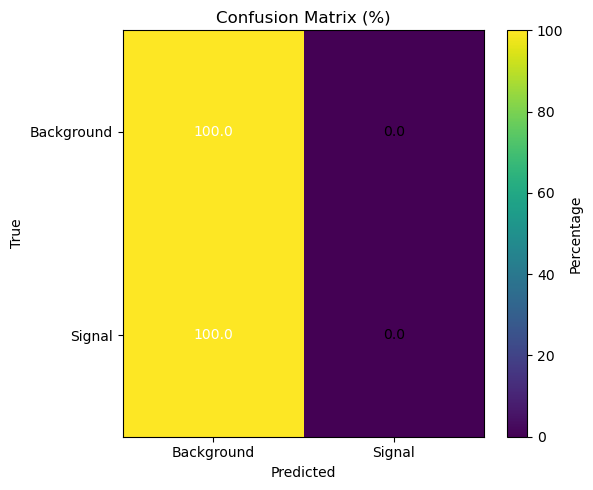

In [53]:
# Cell 8: Confusion matrix (%) using matplotlib only
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred_class)
cm_percent = cm.astype(float) / cm.sum(axis=1)[:,None] * 100

fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm_percent, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Percentage')
ax.set_xticks([0,1]); ax.set_xticklabels(['Background','Signal'])
ax.set_yticks([0,1]); ax.set_yticklabels(['Background','Signal'])
for i in range(2):
    for j in range(2):
        color = 'white' if cm_percent[i,j] > 50 else 'black'
        ax.text(j, i, f"{cm_percent[i,j]:.1f}", ha='center', va='center', color=color)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix (%)')
plt.tight_layout()
plt.show()

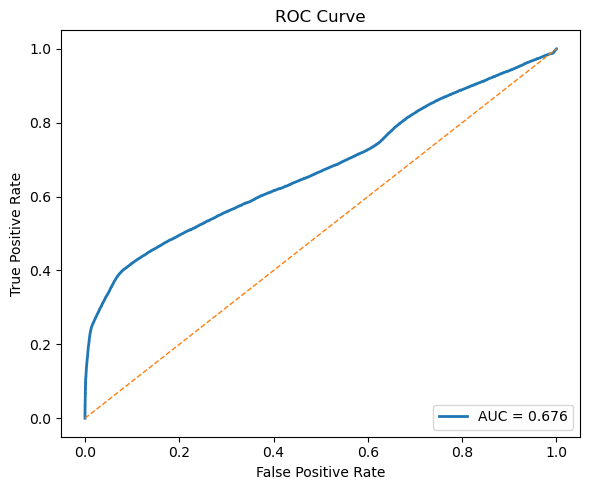

In [50]:
# Cell 9: ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', lw=2)
plt.plot([0,1], [0,1], '--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

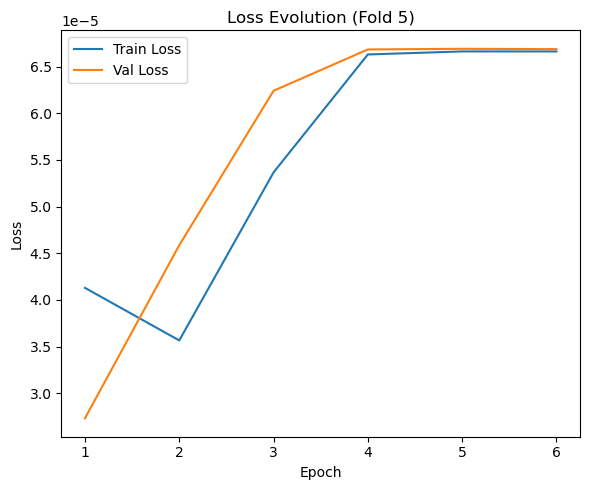

NameError: name 'train_aucs' is not defined

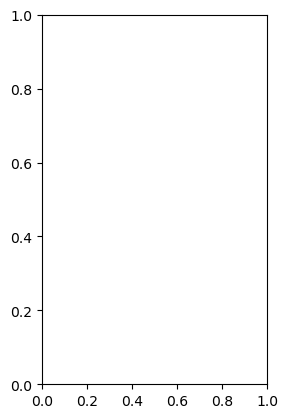

In [51]:
# Cell 10: Training history (you’ll need to collect these during Cell 7)
# Example: assume you stored lists train_losses, val_losses per epoch
# Cell 8: Loss evolution
epochs_range = range(1, len(train_losses)+1)

plt.figure(figsize=(6,5))
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Evolution (Fold {})'.format(FOLDS))
plt.legend()
plt.tight_layout()
plt.show()


# AUC (if you recorded train_aucs, val_aucs)
plt.subplot(1,2,2)
plt.plot(epochs_range, train_aucs, label='Train AUC')
plt.plot(epochs_range, val_aucs,   label='Val AUC')
plt.xlabel('Epoch'); plt.ylabel('AUC')
plt.title('AUC Evolution')
plt.legend()

plt.tight_layout()
plt.show()


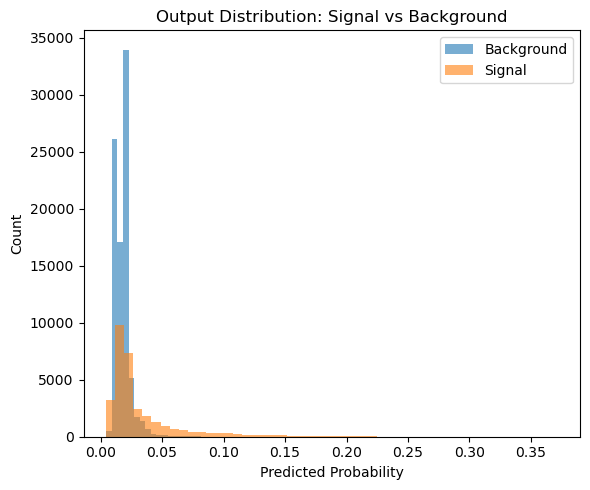

In [ ]:
# Cell 11: Model output distribution
plt.figure(figsize=(6,5))
plt.hist(y_pred[y_val==0], bins=50, alpha=0.6, label='Background')
plt.hist(y_pred[y_val==1], bins=50, alpha=0.6, label='Signal')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title('Output Distribution: Signal vs Background')
plt.legend()
plt.tight_layout()
plt.show()
